In [ ]:
#%%

import torch
import numpy as np
import os

from sklearn.metrics import confusion_matrix
from utils import get_ecg, qrs_detection, get_segments, plot, plot_confusion_matrix
from data import build_dataloader
from train import learn, cnn_feed_lstm

PATH = "/Users/nguyenvietthai/Downloads/Datamoi/mat_files"
BATCH_SIZE = 2048
EPOCH = 50
FS = 300
LENGTH = 9000
LR = 1e-3
RESAMP = False

In [ ]:
#%%

try:
    segments = np.load('/Users/nguyenvietthai/Downloads/Datamoi/mat_files/segment.npy')
except FileNotFoundError:
    print("File not found. Generating segments...")
    PATH = '/Users/nguyenvietthai/Downloads/Datamoi/mat_files' 
    LENGTH = 9000
    signals, labels = get_ecg(PATH, segment_length=LENGTH)
    
    if len(signals) == 0:
        raise ValueError("No signals found. Please check the PATH and LENGTH parameters.")
    
    segments = np.zeros((245990, 1001))
    k = 0
    
    for i, record in enumerate(signals):
        print(f"Running record {i + 1} of {len(signals)}")
        rp = qrs_detection(record, sample_rate=FS)
        seg = get_segments(record, rp, labels[i])
        
        if seg is not None:
            segments[k:k+seg.shape[0], :] = seg
            k += seg.shape[0]
    
    del signals, labels
    
    np.save('/Users/nguyenvietthai/Downloads/Datamoi/mat_files/segment.npy', segments)

In [ ]:
#%%

X, y = segments[:, :-1], segments[:, -1][:, np.newaxis]
del segments

train, test = build_dataloader(X, y, resamp=RESAMP, batch_size=BATCH_SIZE)
del X, y

net = cnn_feed_lstm()
try:
    params = torch.load("../params/net_0.81.pkl")
    net.load_state_dict(params["model_state_dict"])
except:
    pass

Start building dataloader.


Start training.
Epoch:  1  | Loss: 0.028  | F1 Score: 0.97
              precision    recall  f1-score   support

          SB       0.99      0.98      0.98     30807
        AFIB       0.86      0.95      0.90      4392
        GSVT       0.82      0.88      0.84       441
          SR       0.90      0.86      0.88      1259

    accuracy                           0.97     36899
   macro avg       0.89      0.91      0.90     36899
weighted avg       0.97      0.97      0.97     36899

Epoch:  2  | Loss: 0.108  | F1 Score: 0.98
              precision    recall  f1-score   support

          SB       0.98      0.99      0.99     30807
        AFIB       0.94      0.91      0.93      4392
        GSVT       0.83      0.88      0.86       441
          SR       0.95      0.83      0.88      1259

    accuracy                           0.98     36899
   macro avg       0.93      0.90      0.91     36899
weighted avg       0.98      0.98      0.97     36899

Epoch:  3  | Loss: 0.049  | 

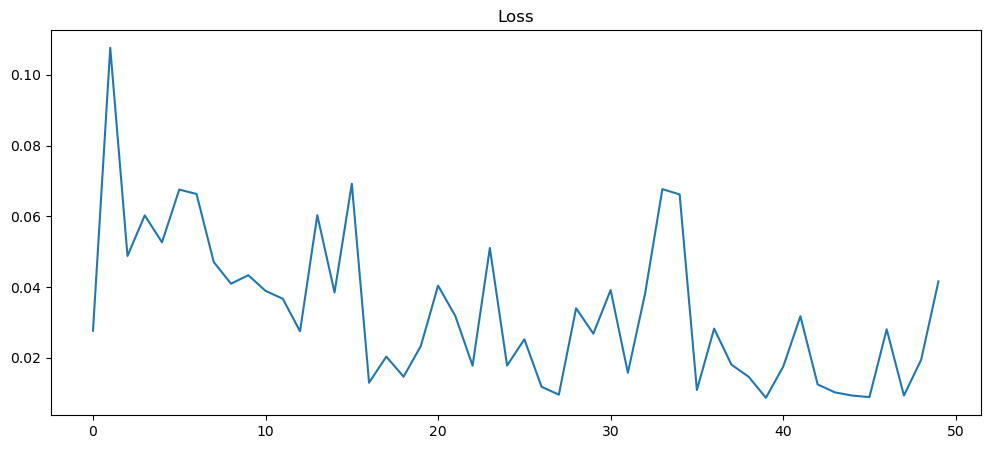

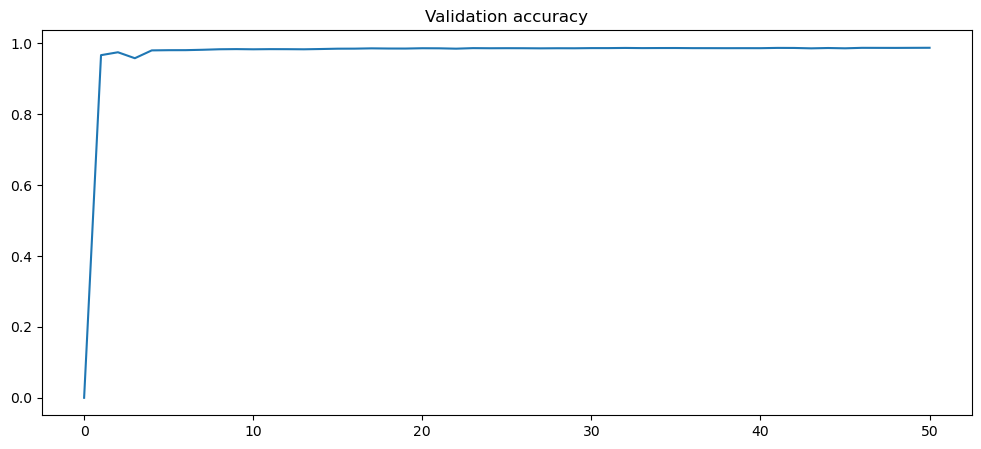

In [ ]:
#%%

loss, val_score, predictions, true_labels = learn(net, train, test, lr=LR, epoch=EPOCH)
plot(loss, val_score)

Confusion matrix, without normalization


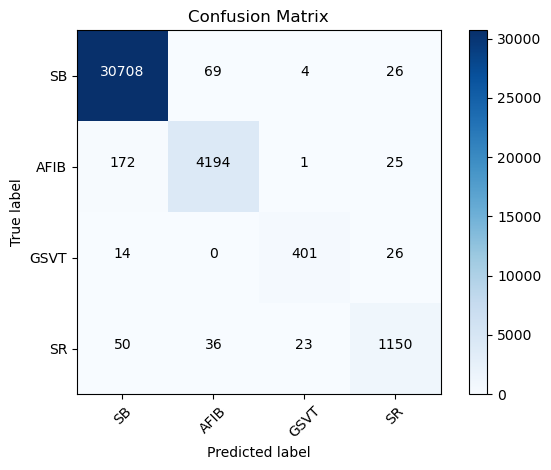

In [ ]:
#%%

cm = confusion_matrix(true_labels,predictions)
classes = ['SB', 'AFIB', 'GSVT', 'SR']

# Plot the confusion matrix
plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix')